In [1]:
import Zip
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import math

# Channels in the detector
det_ch = { 'tpc': list(range(0, 247+1)), 'veto': list(range(248, 253+1)), 
          'sum_wv': [254], 'busy_on': [255], 'busy_off': [256],
          'hev_on': [257], 'hev_off': [258], 'muon_veto_trigger': [259], } 
n_channels = 260

# The data files
NG = Zip.ReadZipped("/data/nikhefproject/data/xenon1t/NG") # Neutron data
Rn220 = Zip.ReadZipped("/data/nikhefproject/data/xenon1t/Rn220") # Rn-220 data

In [2]:
def Peaks(pulse):
    
    # The standard variables
    q = 0
    left_t, right_t = 0, 0
    baseline = 16382.
    std = 2.3
    ch = pulse.channel
    wave = pulse.raw_data
    
    # The index for the minimum
    minindex = pulse.right
    
    # Variables for the averages
    ratio = 1
    avfound = 0
    samplelist = []

    s = np.std(wave)
    delta = baseline - np.min(wave)
    if min(s, delta) > 5*std:
        for samples in enumerate(wave):
            base_sub = samples[1] - baseline
            if abs(base_sub) > 5*std:
                q = q + base_sub
             
            # Compute the average of the previous samples
            av = np.average(samplelist)
            
            # left_t is assigned when a significant deviation from the average is recorded
            if abs(samples[1] - av) > 20 and left_t == 0:
                left_t = samples[0]
                avfound = av
             
            # Find the index for the minimum
            if samples[1] == np.min(wave):
                minindex = samples[0]

            # right_t is assigned in a similar way as left_t
            if abs(samples[1] - avfound) < 20 and samples[0] > minindex and right_t == 0: 
                right_t = samples[0]
                
            # Add the current sample to the sample list
            samplelist.append(samples[1])
        ratio = np.min(wave)/int(avfound)
    else:
        baseline = np.average(wave)
        std = s
    width = right_t - left_t 
    if width != 0 and -q/width < 3*std or ratio >= 0.99:
        q = 0
    return (ch, q, width, pulse.left+left_t, ratio)

In [3]:
# A waveform reader function
def Waveform(eventnr):
    event = NG.get_single_event(eventnr)
                                
    #The variables that check if a channel is the minimum channel
    adcmin = 16382
    minchannel = 0
    
    #A list that holds all the channels with significant pulses 
    channellist = []
    
    #Create the datapoint arrays
    n = 350000  
    ts = np.ones((n_channels, n), dtype=np.int16)
    ts = ts * 16382 
    t = np.linspace(0, n, n) 
    
    #Loop over all pulses in the event
    for p in event.pulses:
        ch = p.channel
        i = np.zeros(n_channels, dtype = int)
        #print(p.channel, ": ", p.left, p.right-p.left)
        for adc in p.raw_data:
            
            #Add the ADC value to the appropriate channel array
            ts[ch][p.left + i[ch]] = adc
            i[ch] = i[ch] + 1
            
            #Append all significant main channels to the list
            if adc < 15000 and ch not in channellist and ch in det_ch['tpc']:
                channellist.append(ch)
                
            #Check which channel is the minimum channel
            if adc < adcmin:
                adcmin = adc
                minchannel = ch
                
    #Sort for convenience
    channellist.sort()
    return t, ts, channellist, minchannel

/usr/lib/python3/dist-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


254 :  -73207.0 36 100056 |  0.8683125
254 :  -321981.0 194 100570 |  0.7826875
254 :  -489031.0 240 102722 |  0.735238929197
254 :  -1826195.0 402 103550 |  0.0576718583849


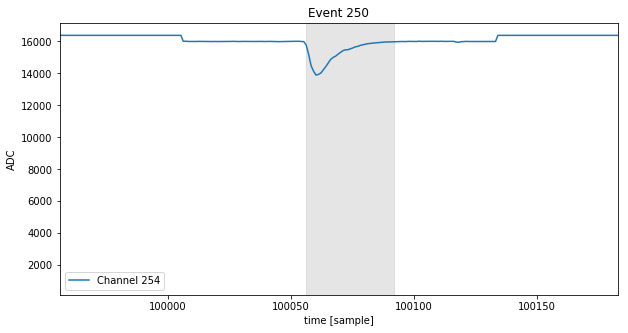

In [4]:
%matplotlib inline
event = NG.get_single_event(250)

t, ts, channellist, minchannel = Waveform(event.event_number)

figs, ax = plt.subplots(figsize = (10.,5.))
ax.plot(t, ts[254], label='Channel 254')
ax.set_ylabel("ADC")
ax.set_xlabel("time [sample]")
ax.set_title('Event ' + str(event.event_number))
ax.legend()

peakchecker = 0
for p in event.pulses:
    if p.channel == 254:
        (ch, q, width, t0, ratio) = Peaks(p)
        if q < 0:
            peakchecker += 1
            print(ch, ": ", q, width, t0, "| ", ratio)
            ax.add_patch(patches.Rectangle((t0, 0), width, 20000, color='grey', alpha=0.2))
            
            # Select the peak that you want to investigate
            if peakchecker == 1:
                ax.set_xlim(p.left - 50, p.right + 50)